# **Libraries**

In [47]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpContinuous, value

# **Load Data**

In [2]:
# inventory
raw_inventory_china = pd.read_csv("raw_inventory_china.csv")

# inbound
raw_inbound_china = pd.read_csv("raw_inbound_china.csv")

# outbound
raw_outbound_china = pd.read_csv("raw_outbound_china.csv") 

### **Sample of Each Dataset**

In [46]:
raw_inbound_china.sample(5)

,INBOUND_DATE,PLANT_NAME,MATERIAL_NAME,DATE,Quantity_KT_In
12440,2024-11-24,CHINA-WAREHOUSE,MAT-0144,2024-11-24,0.0255


In [4]:
raw_inventory_china.sample(5)

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,STOCK_SELL_VALUE,CURRENCY,DATE,Quantity_KT_Inventory
0,2023-12-31,CHINA-WAREHOUSE,MAT-0045,SCRAP,211,CNY,2023-12-31,0.000164
1,2023-12-31,CHINA-WAREHOUSE,MAT-0193,6024,87666,CNY,2023-12-31,0.000000
2,2023-12-31,CHINA-WAREHOUSE,MAT-0193,5755,414419,CNY,2023-12-31,0.070720
3,2023-12-31,CHINA-WAREHOUSE,MAT-0193,3142,71726,CNY,2023-12-31,0.012240
4,2023-12-31,CHINA-WAREHOUSE,MAT-0193,6734,15939,CNY,2023-12-31,0.002720


In [5]:
raw_outbound_china.sample(5)

,OUTBOUND_DATE,PLANT_NAME,MODE_OF_TRANSPORT,MATERIAL_NAME,CUSTOMER_NUMBER,DATE,Quantity_KT_Out
0,2024-01-02,CHINA-WAREHOUSE,Truck,MAT-0013,CST-00001,2024-01-02,0.0255
1,2024-01-02,CHINA-WAREHOUSE,Truck,MAT-0013,CST-00001,2024-01-02,0.0255
2,2024-01-02,CHINA-WAREHOUSE,Truck,MAT-0268,CST-00002,2024-01-02,0.0255
3,2024-01-02,CHINA-WAREHOUSE,Truck,MAT-0268,CST-00002,2024-01-02,0.0255
4,2024-01-02,CHINA-WAREHOUSE,Truck,MAT-0268,CST-00002,2024-01-02,0.0255


---

# **China**

### **Time Range Selection**

In [6]:
print("Inbound dates:", raw_inbound_china['INBOUND_DATE'].min(), "-", raw_inbound_china['INBOUND_DATE'].max())
print("Outbound dates:", raw_outbound_china['OUTBOUND_DATE'].min(), "-", raw_outbound_china['OUTBOUND_DATE'].max())
print("Inventory dates:", raw_inventory_china['BALANCE_AS_OF_DATE'].min(), "-", raw_inventory_china['BALANCE_AS_OF_DATE'].max())

Inbound dates: 2023-11-03 - 2024-12-24
Outbound dates: 2024-01-02 - 2024-12-31
Inventory dates: 2023-12-31 - 2024-12-31


In [7]:
raw_inbound_china['INBOUND_DATE'] = pd.to_datetime(raw_inbound_china['INBOUND_DATE'])
raw_inventory_china['BALANCE_AS_OF_DATE'] = pd.to_datetime(raw_inventory_china['BALANCE_AS_OF_DATE'])
raw_outbound_china['OUTBOUND_DATE'] = pd.to_datetime(raw_outbound_china['OUTBOUND_DATE'])

In [ ]:
start_date = pd.to_datetime('2024-01-01')
end_date   = pd.to_datetime('2024-12-31')

In [ ]:
inbound_china = raw_inbound_china[
    (raw_inbound_china['INBOUND_DATE'] >= start_date) & 
    (raw_inbound_china['INBOUND_DATE'] <= end_date)
].copy()

outbound_china = raw_outbound_china[
    (raw_outbound_china['OUTBOUND_DATE'] >= start_date) & 
    (raw_outbound_china['OUTBOUND_DATE'] <= end_date)
].copy()

inventory_china = raw_inventory_china[
    (raw_inventory_china['BALANCE_AS_OF_DATE'] >= start_date) & 
    (raw_inventory_china['BALANCE_AS_OF_DATE'] <= end_date)
].copy()

In [10]:
print("Inbound dates:", inbound_china['INBOUND_DATE'].min(), "-", raw_inbound_china['INBOUND_DATE'].max())
print("Outbound dates:", outbound_china['OUTBOUND_DATE'].min(), "-", raw_outbound_china['OUTBOUND_DATE'].max())
print("Inventory dates:", inventory_china['BALANCE_AS_OF_DATE'].min(), "-", raw_inventory_china['BALANCE_AS_OF_DATE'].max())

Inbound dates: 2024-01-03 00:00:00 - 2024-12-24 00:00:00
Outbound dates: 2024-01-02 00:00:00 - 2024-12-31 00:00:00
Inventory dates: 2024-01-31 00:00:00 - 2024-12-31 00:00:00


---

# **EDA**

### **Monthly of Inventory, Inbound & Outbound**

**Inventory**

In [12]:
inventory_china['month'] = inventory_china['BALANCE_AS_OF_DATE'].dt.to_period('M').dt.to_timestamp()

Inventory_monthly_china = (
    inventory_china.groupby(['month', 'PLANT_NAME'])['Quantity_KT_Inventory']
    .sum()
    .reset_index()
)
Inventory_monthly_china.head(5)

,month,PLANT_NAME,Quantity_KT_Inventory
0,2024-01-01,CHINA-WAREHOUSE,39.023693
1,2024-02-01,CHINA-WAREHOUSE,46.217648
2,2024-03-01,CHINA-WAREHOUSE,48.478708
3,2024-04-01,CHINA-WAREHOUSE,48.415015
4,2024-05-01,CHINA-WAREHOUSE,52.826486


**Inbound**

In [13]:
inbound_china['month'] = inbound_china['INBOUND_DATE'].dt.to_period('M').dt.to_timestamp()

Inbound_monthly_china = (
    inbound_china.groupby(['month', 'PLANT_NAME'])['Quantity_KT_In']
    .sum()
    .reset_index()
)
Inbound_monthly_china.head(5)

,month,PLANT_NAME,Quantity_KT_In
0,2024-01-01,CHINA-WAREHOUSE,25.025125
1,2024-02-01,CHINA-WAREHOUSE,16.469113
2,2024-03-01,CHINA-WAREHOUSE,33.598812
3,2024-04-01,CHINA-WAREHOUSE,23.836500
4,2024-05-01,CHINA-WAREHOUSE,29.770405


**Outbound**

In [14]:
outbound_china['month'] = outbound_china['OUTBOUND_DATE'].dt.to_period('M').dt.to_timestamp()

outbound_monthly_china = (
    outbound_china.groupby(['month', 'PLANT_NAME'])['Quantity_KT_Out']
    .sum()
    .reset_index()
)
outbound_monthly_china.head(5)

,month,PLANT_NAME,Quantity_KT_Out
0,2024-01-01,CHINA-WAREHOUSE,25.68777
1,2024-02-01,CHINA-WAREHOUSE,14.02565
2,2024-03-01,CHINA-WAREHOUSE,20.43856
3,2024-04-01,CHINA-WAREHOUSE,21.06260
4,2024-05-01,CHINA-WAREHOUSE,22.76281


## **Merge**

In [15]:
df = pd.merge(
    Inbound_monthly_china,
    Inventory_monthly_china,
    on=['month', 'PLANT_NAME'],
    how='left'
)
df = pd.merge(
    df,
    outbound_monthly_china,
    on=['month', 'PLANT_NAME'],
    how='left'
)
df.fillna(0, inplace=True)
df = df[['month', 'PLANT_NAME', 'Quantity_KT_In', 'Quantity_KT_Out', 'Quantity_KT_Inventory']]
df.sample(5)

,month,PLANT_NAME,Quantity_KT_In,Quantity_KT_Inventory,Quantity_KT_Out
10,2024-11-01,CHINA-WAREHOUSE,15.277488,54.764596,22.24040
1,2024-02-01,CHINA-WAREHOUSE,16.469113,46.217648,14.02565
0,2024-01-01,CHINA-WAREHOUSE,25.025125,39.023693,25.68777
4,2024-05-01,CHINA-WAREHOUSE,29.770405,52.826486,22.76281
8,2024-09-01,CHINA-WAREHOUSE,19.945650,66.701368,26.56943


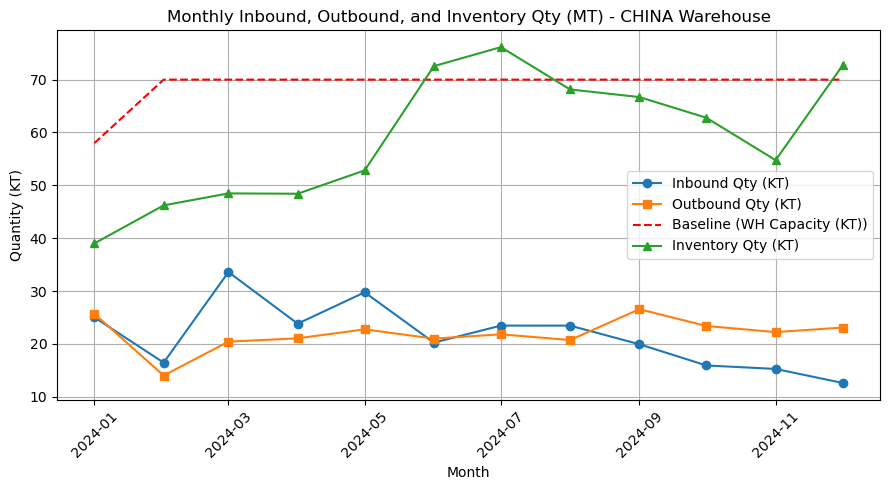

In [48]:
y = [58]*1 + [70] * 11
plt.figure(figsize=(9, 5))
plt.plot(df['month'], df['Quantity_KT_In'], marker='o', label='Inbound Qty (KT)')
plt.plot(df['month'], df['Quantity_KT_Out'], marker='s', label='Outbound Qty (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity (KT))')
plt.plot(df['month'], df['Quantity_KT_Inventory'], marker='^', label='Inventory Qty (KT)')
plt.title('Monthly Inbound, Outbound, and Inventory Qty (MT) - CHINA Warehouse')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

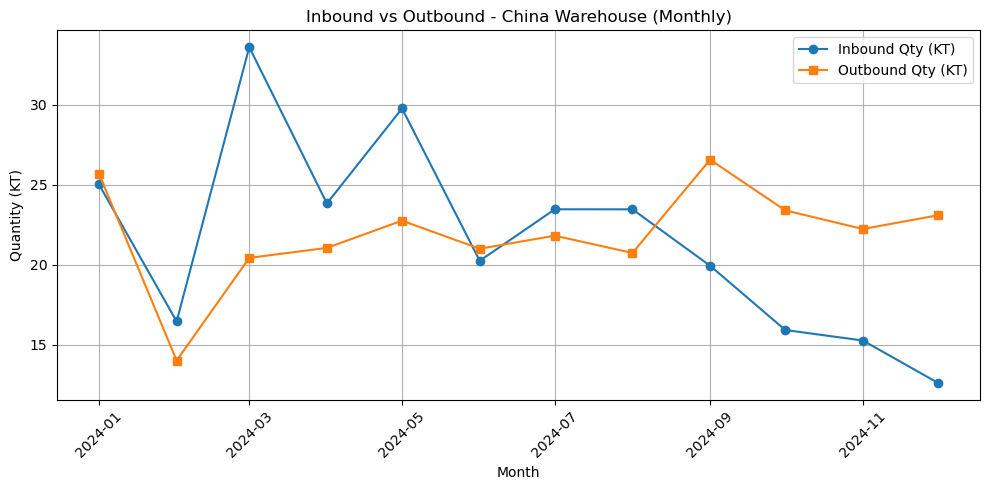

In [18]:
plt.figure(figsize=(10, 5))

plt.plot(df['month'], df['Quantity_KT_In'], marker='o', label='Inbound Qty (KT)')
plt.plot(df['month'], df['Quantity_KT_Out'], marker='s', label='Outbound Qty (KT)')

plt.title('Inbound vs Outbound - China Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

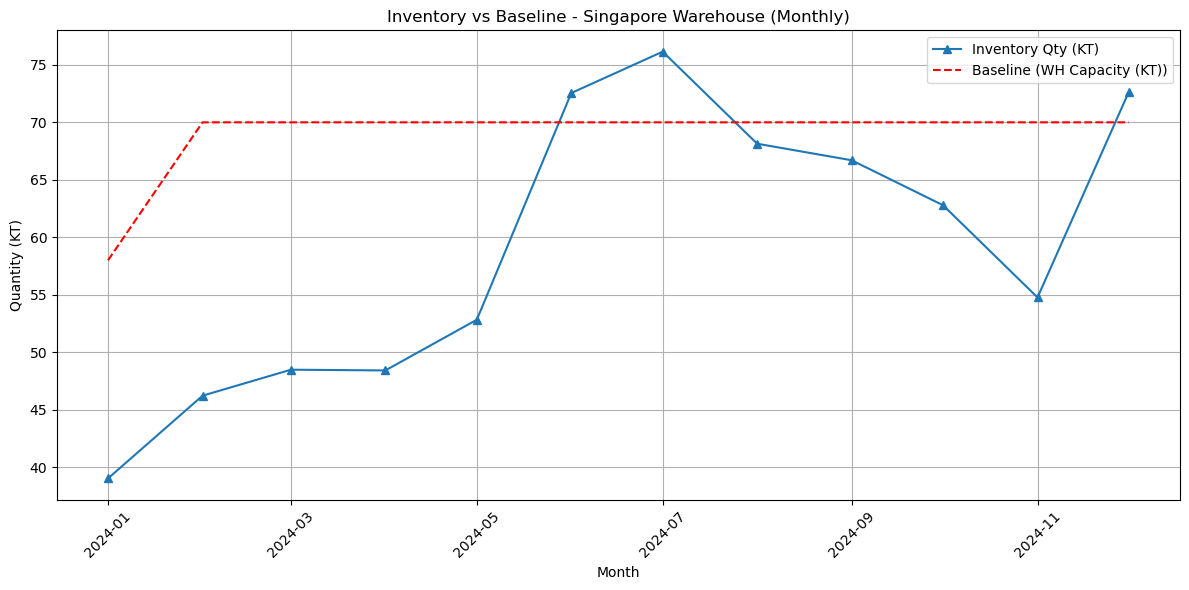

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_KT_Inventory'], marker='^', label='Inventory Qty (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity (KT))')
plt.title('Inventory vs Baseline - Singapore Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

# **Forecasting**

In [20]:
china_data = {
    'Month': ['Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24', 'Aug-24', 'Sep-24', 'Oct-24', 'Nov-24', 'Dec-24'],
    'Total Cap (KT)': [58, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70],
    'Predicted Outbound (KT)': [22.6, 21.7, 22, 23.1, 26.7, 21.9, 36.2, 22.9, 26.4, 28.6, 21.1, 21.8],
    'Predicted Inventory (KT)': [40, 37, 35, 36, 36, 41, 44, 42, 42, 42, 40, 15]
}
china_predicted = pd.DataFrame(china_data)
china_predicted['Month'] = pd.to_datetime(china_predicted['Month'], format='%b-%y').dt.to_period('M')

In [21]:
china_predicted

,Month,Total Cap (KT),Predicted Outbound (KT),Predicted Inventory (KT)
0,2024-01,58,22.6,40
1,2024-02,70,21.7,37
2,2024-03,70,22.0,35
3,2024-04,70,23.1,36
4,2024-05,70,26.7,36
5,2024-06,70,21.9,41
6,2024-07,70,36.2,44
7,2024-08,70,22.9,42
8,2024-09,70,26.4,42
9,2024-10,70,28.6,42


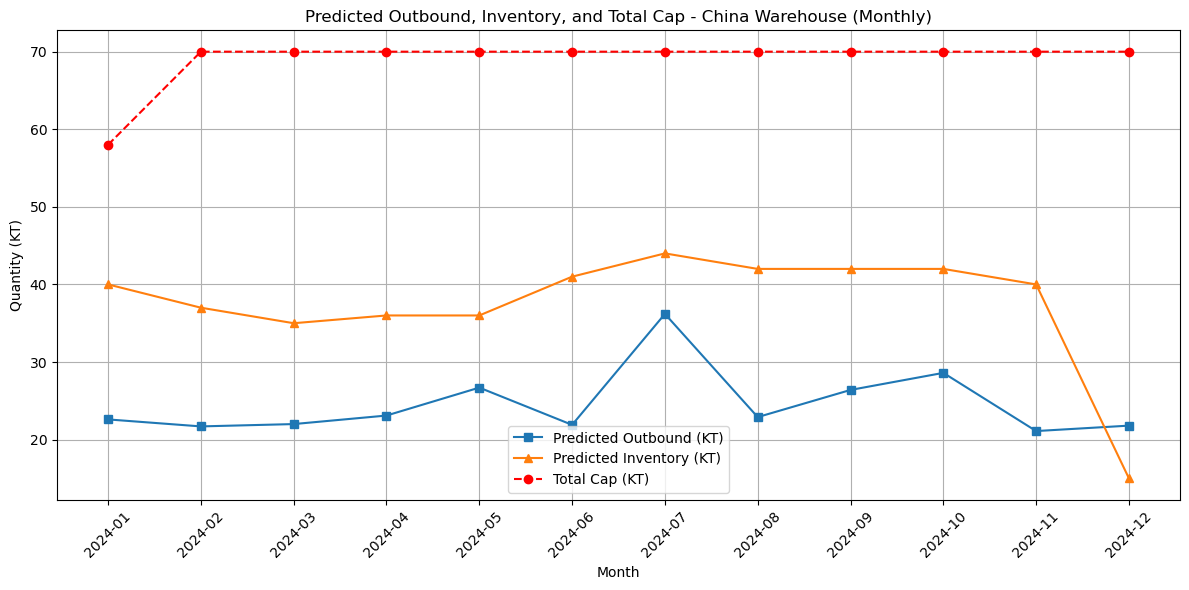

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(china_predicted['Month'].astype(str), china_predicted['Predicted Outbound (KT)'], marker='s', label='Predicted Outbound (KT)')
plt.plot(china_predicted['Month'].astype(str), china_predicted['Predicted Inventory (KT)'], marker='^', label='Predicted Inventory (KT)')
plt.plot(china_predicted['Month'].astype(str), china_predicted['Total Cap (KT)'], marker='o', linestyle='--', color='red', label='Total Cap (KT)')

plt.title('Predicted Outbound, Inventory, and Total Cap - China Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Inventory Pred vs Actual**

In [23]:
comparison = df[['month', 'Quantity_KT_Inventory']].copy()
comparison['Predicted_Inventory'] = comparison['month'].apply(
    lambda m: china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m, 'Predicted Inventory (KT)'].values[0]
    if not china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m].empty else None
)
comparison['Deviation'] = comparison['Quantity_KT_Inventory'] - comparison['Predicted_Inventory']

print("Actual vs Predicted Inventory (China Warehouse):")
comparison

Actual vs Predicted Inventory (China Warehouse):


,month,Quantity_KT_Inventory,Predicted_Inventory,Deviation
0,2024-01-01,39.023693,40,-0.976307
1,2024-02-01,46.217648,37,9.217648
2,2024-03-01,48.478708,35,13.478708
3,2024-04-01,48.415015,36,12.415015
4,2024-05-01,52.826486,36,16.826486
5,2024-06-01,72.547766,41,31.547766
6,2024-07-01,76.147124,44,32.147124
7,2024-08-01,68.138683,42,26.138683
8,2024-09-01,66.701368,42,24.701368
9,2024-10-01,62.785369,42,20.785369


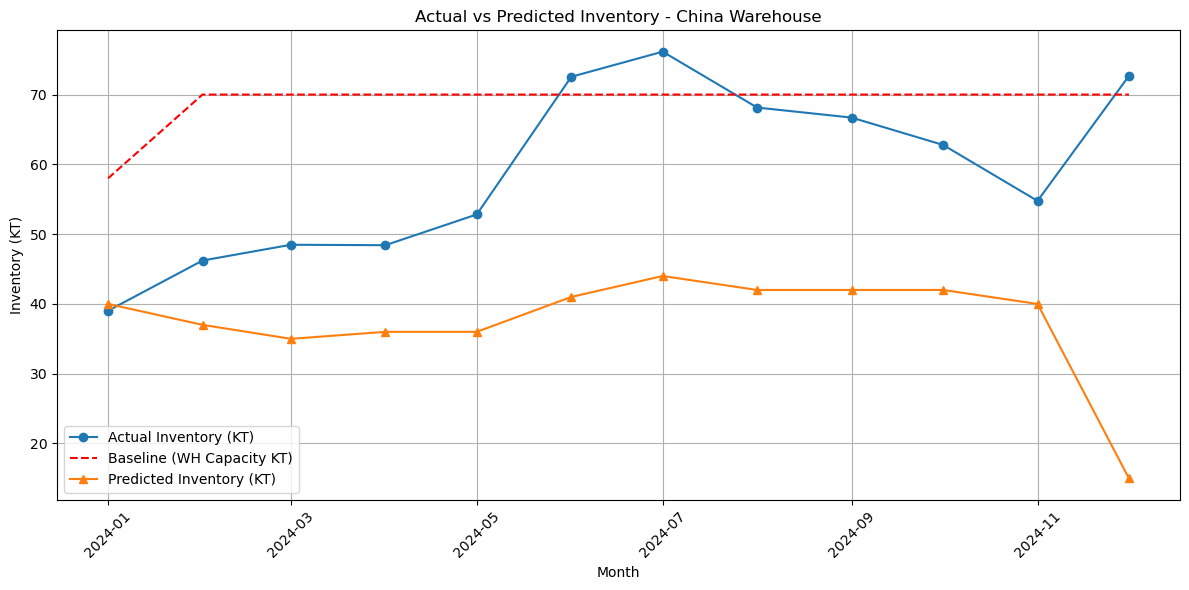

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_KT_Inventory'], marker='o', label='Actual Inventory (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity KT)')
plt.plot(china_predicted['Month'].dt.to_timestamp(), china_predicted['Predicted Inventory (KT)'], marker='^', label='Predicted Inventory (KT)')
plt.title('Actual vs Predicted Inventory - China Warehouse')
plt.xlabel('Month')
plt.ylabel('Inventory (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Adjust Inventory Predicted**

In [50]:
comparison_valid = comparison.dropna(subset=['Predicted_Inventory', 'Quantity_KT_Inventory'])

X = comparison_valid[['Predicted_Inventory']]
y = comparison_valid['Quantity_KT_Inventory']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

cut_off_date = pd.to_datetime('2024-09-30')

train_mask = comparison_valid['month'] <= cut_off_date
test_mask = comparison_valid['month'] > cut_off_date

X_train = X_scaled[train_mask]
X_test = X_scaled[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.005,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)

model.fit(X_train, y_train) 

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"[Train] MAE: {mean_absolute_error(y_train, y_train_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"[Test ] MAE: {mean_absolute_error(y_test, y_test_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")

[Train] MAE: 7.15 | RMSE: 8.32
[Test ] MAE: 6.88 | RMSE: 11.14


In [51]:
X_all = scaler.transform(comparison[['Predicted_Inventory']].fillna(0))
comparison['Predicted_Adjusted'] = model.predict(X_all)
comparison['Deviation_Adjusted'] = comparison['Quantity_KT_Inventory'] - comparison['Predicted_Adjusted']


fig = px.line(comparison, x='month', y=['Quantity_KT_Inventory', 'Predicted_Inventory', 'Predicted_Adjusted'],
              title='Actual vs Predicted Inventory', markers=True)
fig.update_layout(yaxis_title='Inventory (KT)', xaxis_title='Month')
fig.show()

# **Outbound Pred vs Actual**

In [27]:
outbound_comparison = df[['month', 'Quantity_KT_Out']].copy()
outbound_comparison['Predicted_Outbound'] = outbound_comparison['month'].apply(
    lambda m: china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m, 'Predicted Outbound (KT)'].values[0]
    if not china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m].empty else None
)
outbound_comparison['Deviation'] = outbound_comparison['Quantity_KT_Out'] - outbound_comparison['Predicted_Outbound']

print("Actual vs Predicted Outbound (China Warehouse):")
outbound_comparison

Actual vs Predicted Outbound (China Warehouse):


,month,Quantity_KT_Out,Predicted_Outbound,Deviation
0,2024-01-01,25.68777,22.6,3.08777
1,2024-02-01,14.02565,21.7,-7.67435
2,2024-03-01,20.43856,22.0,-1.56144
3,2024-04-01,21.06260,23.1,-2.03740
4,2024-05-01,22.76281,26.7,-3.93719
5,2024-06-01,21.01019,21.9,-0.88981
6,2024-07-01,21.82408,36.2,-14.37592
7,2024-08-01,20.74491,22.9,-2.15509
8,2024-09-01,26.56943,26.4,0.16943
9,2024-10-01,23.40413,28.6,-5.19587


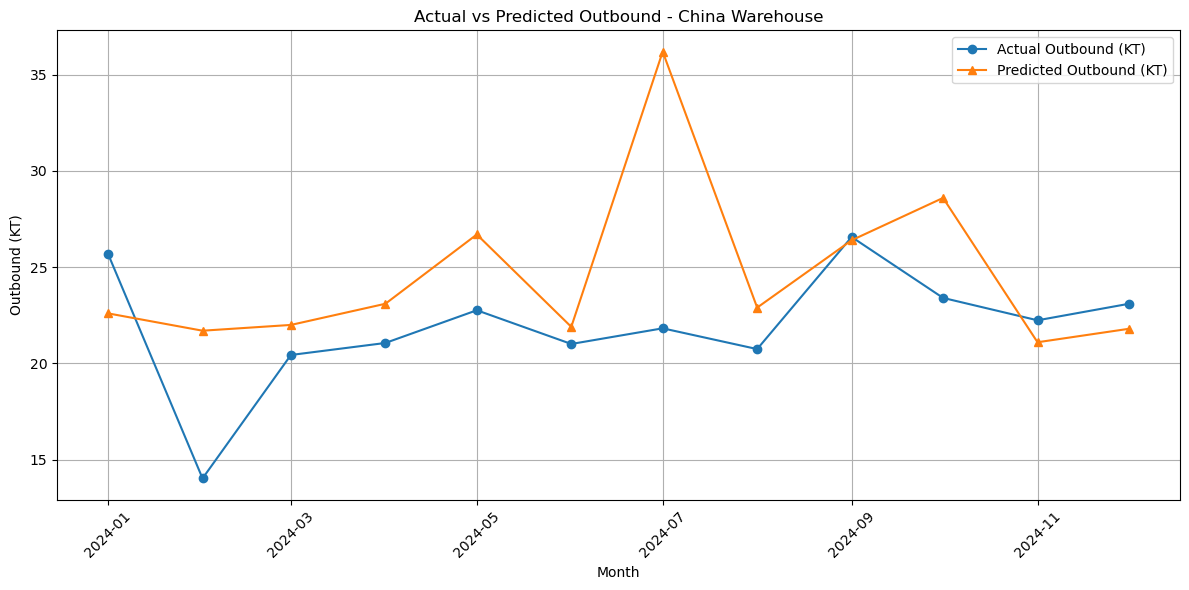

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_KT_Out'], marker='o', label='Actual Outbound (KT)')
plt.plot(china_predicted['Month'].dt.to_timestamp(), china_predicted['Predicted Outbound (KT)'], marker='^', label='Predicted Outbound (KT)')
plt.title('Actual vs Predicted Outbound - China Warehouse')
plt.xlabel('Month')
plt.ylabel('Outbound (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Adjust Outbound Predicted**

In [52]:
outbound_valid = outbound_comparison.dropna(subset=['Predicted_Outbound', 'Quantity_KT_Out'])

X_out = outbound_valid[['Predicted_Outbound']]
y_out = outbound_valid['Quantity_KT_Out']

scaler_out = RobustScaler()
X_out_scaled = scaler_out.fit_transform(X_out)

train_mask = outbound_valid['month'] <= cut_off_date
test_mask = outbound_valid['month'] > cut_off_date

X_out_train = X_out_scaled[train_mask] 
X_out_test = X_out_scaled[test_mask]  
y_out_train = y_out[train_mask]      
y_out_test = y_out[test_mask]          

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
)

model.fit(X_out_train, y_out_train)

y_out_train_pred = model.predict(X_out_train)
y_out_test_pred = model.predict(X_out_test)

print(f"[Train] MAE: {mean_absolute_error(y_out_train, y_out_train_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_out_train, y_out_train_pred)):.2f}")
print(f"[Test ] MAE: {mean_absolute_error(y_out_test, y_out_test_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_out_test, y_out_test_pred)):.2f}")

[Train] MAE: 2.02 | RMSE: 2.54
[Test ] MAE: 2.19 | RMSE: 2.70


In [31]:
X_out_all = scaler_out.transform(outbound_comparison[['Predicted_Outbound']].fillna(0))
outbound_comparison['Predicted_Outbound_Adjusted'] = model.predict(X_out_all)
outbound_comparison['Deviation_Adjusted'] = outbound_comparison['Quantity_KT_Out'] - outbound_comparison['Predicted_Outbound_Adjusted']


fig = px.line(
    outbound_comparison,
    x='month',
    y=['Quantity_KT_Out', 'Predicted_Outbound', 'Predicted_Outbound_Adjusted'],
    title='Actual vs Predicted Outbound',
    markers=True
)

fig.update_layout(yaxis_title='Outbound (KT)', xaxis_title='Month')
fig.show()

---

# **Optimization**

### **Create Dataframe For Optimization Model**

In [ ]:
optimize = pd.DataFrame({
    'Actual Inbound': Inbound_monthly_china['Quantity_KT_In'],
    'Actual Outbound': outbound_monthly_china['Quantity_KT_Out'],
    'Actual Inventory': Inventory_monthly_china['Quantity_KT_Inventory'],
    'Adjusted Inventory': comparison['Predicted_Adjusted'],
    'Adjusted Outbound': outbound_comparison['Predicted_Outbound_Adjusted'],
    'Capacity' : china_predicted['Total Cap (KT)'].values
})
optimize['Overflow'] = optimize['Adjusted Inventory'] > optimize['Capacity']

In [35]:
optimize

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
0,25.025125,25.68777,39.023693,53.424630,22.136795,58,False
1,16.469113,14.02565,46.217648,53.424630,19.391612,70,False
2,33.598812,20.43856,48.478708,53.424630,20.025016,70,False
3,23.836500,21.06260,48.415015,53.424630,21.977254,70,False
4,29.770405,22.76281,52.826486,53.424630,23.404748,70,False
5,20.254925,21.01019,72.547766,62.843336,19.391612,70,False
6,23.471777,21.82408,76.147124,62.843336,23.404748,70,False
7,23.469684,20.74491,68.138683,62.843336,21.924838,70,False
8,19.945650,26.56943,66.701368,62.843336,23.637345,70,False
9,15.933650,23.40413,62.785369,62.843336,23.404748,70,False


### ---**You Can Append New Records to the `optimize` DataFrame**---

## **Optimization Model Function: Backtesting on Historical Data**

- **Define a Function that applies the optimization logic using historical data to verify model correctness, behavior, and feasibility before applying to future scenarios.**

In [36]:
def run_optimization(optimize):
    model = LpProblem("Inventory_Optimization", LpMinimize)
    n = len(optimize)

    inbound_vars = [LpVariable(f"Inbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    outbound_vars = [LpVariable(f"Outbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    inventory_vars = [LpVariable(f"Inventory_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    overflow_vars = [LpVariable(f"Overflow_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    understock_vars = [LpVariable(f"Understock_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]

    capacity = optimize['Capacity'].values
    adjusted_outbound = optimize['Actual Outbound'].values
    cap_75 = 0.75 * capacity
    cap_80 = 0.8 * capacity

    # Objective: penalize overflow and understock, reward outbound
    model += (
        lpSum(overflow_vars) * 1 +
        lpSum(understock_vars) * 1 -
        lpSum(outbound_vars)
    )

    for i in range(n):
        if i == 0:
            model += inventory_vars[i] == optimize['Actual Inventory'].iloc[0] + inbound_vars[i] - outbound_vars[i]
        else:
            model += inventory_vars[i] == inventory_vars[i - 1] + inbound_vars[i] - outbound_vars[i]

        model += outbound_vars[i] <= adjusted_outbound[i]
        model += inbound_vars[i] >= 5  # supplier constraint

        # Tight overflow/understock constraints
        model += overflow_vars[i] >= inventory_vars[i] - cap_80[i]
        model += understock_vars[i] >= cap_75[i] - inventory_vars[i]
        model += overflow_vars[i] >= 0
        model += understock_vars[i] >= 0

    model.solve()

    optimize['Optimized Inbound'] = [inbound_vars[i].varValue for i in range(n)]
    optimize['Optimized Outbound'] = [outbound_vars[i].varValue for i in range(n)]
    optimize['Optimized Inventory'] = [inventory_vars[i].varValue for i in range(n)]
    optimize['Overflow'] = [overflow_vars[i].varValue for i in range(n)]
    optimize['Understock'] = [understock_vars[i].varValue for i in range(n)]
    optimize['Cap_75'] = cap_75
    optimize['Cap_80'] = cap_80

    return optimize


In [37]:
opt_head_9 = optimize.head(9).copy()

In [38]:
opt_head_9 = run_optimization(opt_head_9)
opt_head_9['Cap_70'] = opt_head_9['Capacity'] * 0.70
opt_head_9['Cap_80'] = opt_head_9['Capacity'] * 0.80

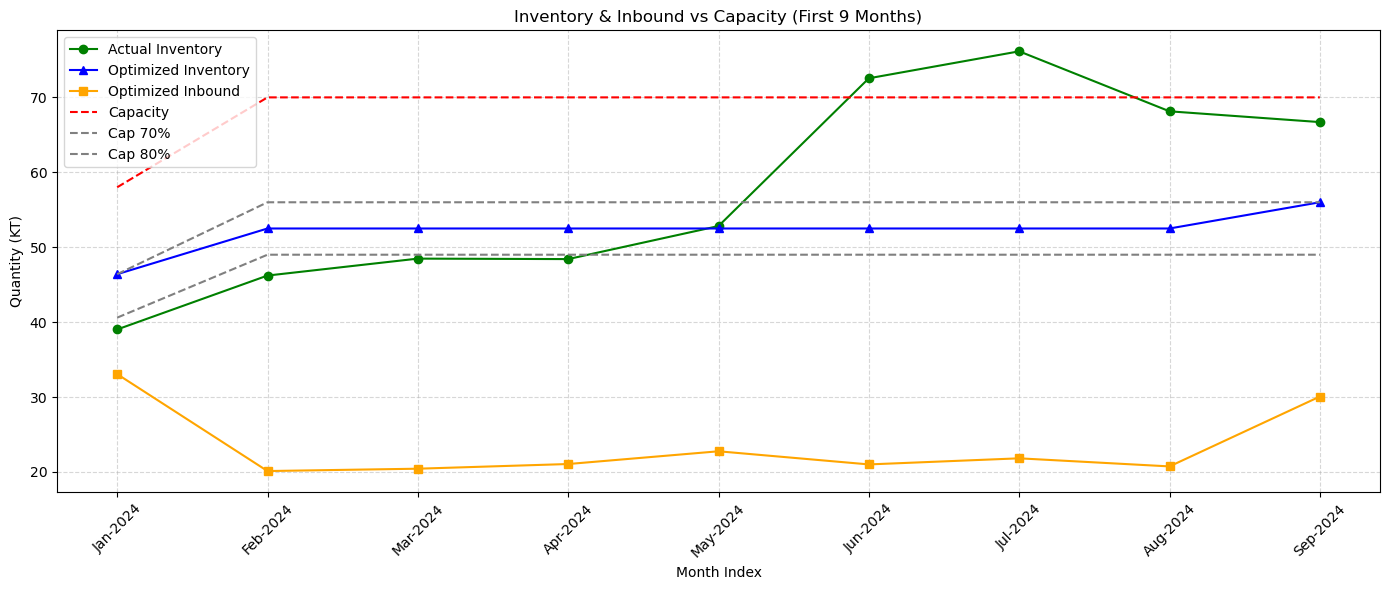

In [39]:
opt_head_9 = opt_head_9.sort_index()
x1 = opt_head_9.index
month_labels = df.loc[x1, 'month'].dt.strftime('%b-%Y').values
plt.figure(figsize=(14,6))

plt.plot(x1, opt_head_9['Actual Inventory'], label='Actual Inventory', color='green', marker='o')
plt.plot(x1, opt_head_9['Optimized Inventory'], label='Optimized Inventory', color='blue', marker='^')
plt.plot(x1, opt_head_9['Optimized Inbound'], label='Optimized Inbound', color='orange', marker='s')

plt.plot(x1, opt_head_9['Capacity'], label='Capacity', color='red', linestyle='--')
plt.plot(x1, opt_head_9['Cap_70'], label='Cap 70%', color='gray', linestyle='--')
plt.plot(x1, opt_head_9['Cap_80'], label='Cap 80%', color='gray', linestyle='--')

plt.title('Inventory & Inbound vs Capacity (First 9 Months)')
plt.xlabel('Month Index')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(x1, month_labels, rotation=45)
plt.tight_layout()
plt.show()

---

## **Build a New Optimization Function for `pred_data`**

- **Construct a new optimization function that applies the same logic as the previous model, adapted to handle `pred_data` (forecasted or incoming new data).**

In [40]:
def run_forecast_optimization(df_forecast, last_inventory):
    n = len(df_forecast)
    
    # Initialize LP model
    model = LpProblem("Inventory_Optimization", LpMinimize)

    # Variables
    inbound_vars = [LpVariable(f"Inbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    outbound_vars = [LpVariable(f"Outbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    inventory_vars = [LpVariable(f"Inventory_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    overflow_vars = [LpVariable(f"Overflow_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    understock_vars = [LpVariable(f"Understock_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]

    # Parameters
    adjusted_outbound = df_forecast['Adjusted Outbound'].values
    adjusted_inventory = df_forecast['Adjusted Inventory'].values
    capacity = df_forecast['Capacity'].values

    cap_80 = 0.8 * capacity
    cap_70 = 0.7 * capacity

    # Inventory balance constraint
    for i in range(n):
        if i == 0:
            model += inventory_vars[i] == last_inventory + inbound_vars[i] - outbound_vars[i]
        else:
            model += inventory_vars[i] == inventory_vars[i-1] + inbound_vars[i] - outbound_vars[i]

    # Constraints: outbound cannot exceed adjusted
    for i in range(n):
        model += outbound_vars[i] <= adjusted_outbound[i]
        model += inbound_vars[i] >= 5

    # Overflow & understock constraints
    for i in range(n):
        model += overflow_vars[i] >= inventory_vars[i] - cap_80[i]
        model += overflow_vars[i] >= 0
        model += understock_vars[i] >= cap_70[i] - inventory_vars[i]
        model += understock_vars[i] >= 0

    # Objective: maximize outbound, penalize overflow and understock
    model += -lpSum(outbound_vars) + lpSum(overflow_vars) * 1 + lpSum(understock_vars) * 1

    # Solve
    model.solve()

    # Collect results
    df_result = df_forecast.copy()
    df_result['Optimized Inbound'] = [value(v) for v in inbound_vars]
    df_result['Optimized Outbound'] = [value(v) for v in outbound_vars]
    df_result['Optimized Inventory'] = [value(v) for v in inventory_vars]
    df_result['Overflow'] = [value(v) for v in overflow_vars]
    df_result['Understock'] = [value(v) for v in understock_vars]
    df_result['Cap_70'] = cap_70
    df_result['Cap_80'] = cap_80

    return df_result


In [41]:
optimize

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
0,25.025125,25.68777,39.023693,53.424630,22.136795,58,False
1,16.469113,14.02565,46.217648,53.424630,19.391612,70,False
2,33.598812,20.43856,48.478708,53.424630,20.025016,70,False
3,23.836500,21.06260,48.415015,53.424630,21.977254,70,False
4,29.770405,22.76281,52.826486,53.424630,23.404748,70,False
5,20.254925,21.01019,72.547766,62.843336,19.391612,70,False
6,23.471777,21.82408,76.147124,62.843336,23.404748,70,False
7,23.469684,20.74491,68.138683,62.843336,21.924838,70,False
8,19.945650,26.56943,66.701368,62.843336,23.637345,70,False
9,15.933650,23.40413,62.785369,62.843336,23.404748,70,False


### **Initial Target for the New Optimization Model: `optimize.iloc[-3:]` (Last 3 Records)**

In [42]:
opt_last3 = optimize.iloc[-3:].copy()

- **The latest inventory value is a key input to the optimization model, as all calculations are anchored from this current stock level.**

In [43]:
opt_start_idx = opt_last3.index[0] 
last_inventory = optimize.loc[opt_start_idx - 1, 'Actual Inventory']
last_inventory

66.701368

In [44]:
opt_last3 = run_forecast_optimization(opt_last3, last_inventory)
opt_last3 = opt_last3.sort_index()

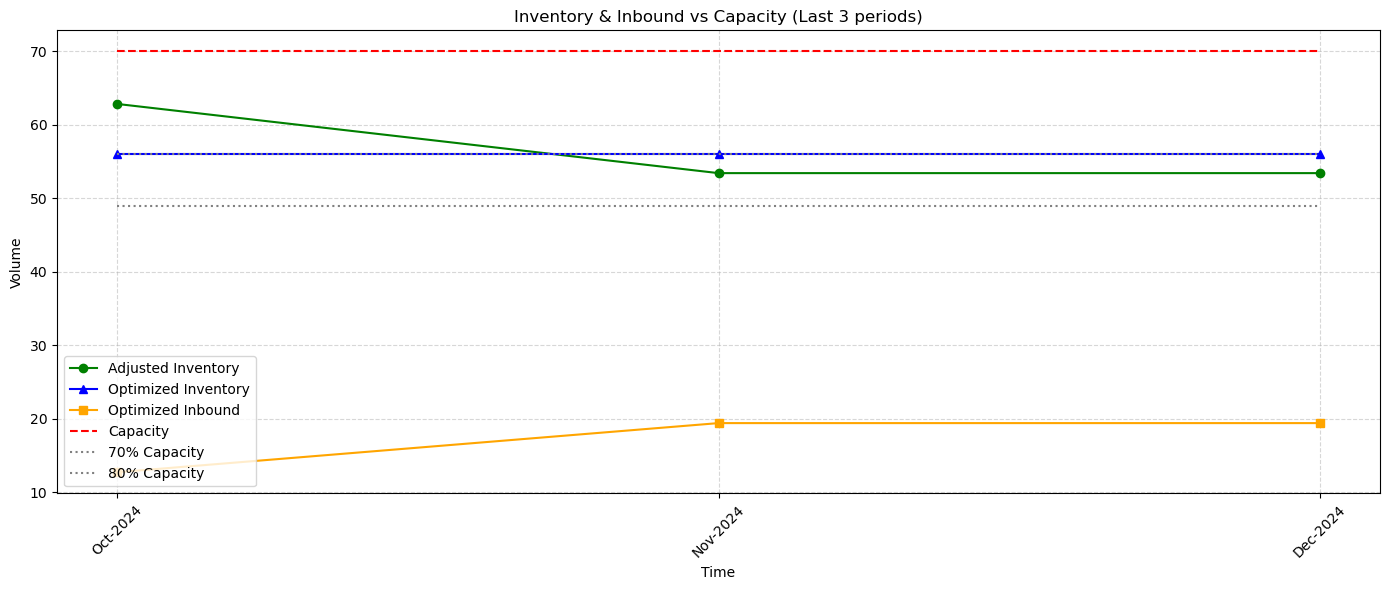

In [45]:
x = opt_last3.index
month_labels_last3 = df.loc[x, 'month'].dt.strftime('%b-%Y').values


plt.figure(figsize=(14,6))

plt.plot(x, opt_last3['Adjusted Inventory'], label='Adjusted Inventory', color='green', marker='o')
plt.plot(x, opt_last3['Optimized Inventory'], label='Optimized Inventory', color='blue', marker='^')
plt.plot(x, opt_last3['Optimized Inbound'], label='Optimized Inbound', color='orange', marker='s')

plt.plot(x, opt_last3['Capacity'], label='Capacity', color='red', linestyle='--')
plt.plot(x, opt_last3['Cap_70'], label='70% Capacity', color='gray', linestyle=':')
plt.plot(x, opt_last3['Cap_80'], label='80% Capacity', color='gray', linestyle=':')

plt.title('Inventory & Inbound vs Capacity (Last 3 periods)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(x, month_labels_last3, rotation=45)
plt.tight_layout()
plt.show()


---

**End of Notebook – Thank you**